# Analysis of Data

### Import libraries and data

In [129]:
import pandas as pd
import geopandas as gpd
from collections import Counter
import re
import contextily as cx
from shapely.geometry import Polygon
from math import floor
from analysis import get_prof_str, plot_ratio_over_time, get_jobs_overtime, make_gif,\
     jobs_not_before_after_specific_year, sort_by_number_of_words, plot_profession_selection_on_map

from paris_methods import create_grid, assign_gridnumber

In [27]:
try:
    rich_data = pd.read_pickle("data/rich_data.pkl")
    rich_data = gpd.GeoDataFrame(rich_data, geometry="geometry")

except:
    rich_data = pd.read_pickle("data/unique_aligned_tagged.pkl")
    #convert to geopandas dataframe
    rich_data = gpd.GeoDataFrame(rich_data, geometry=rich_data.geometry)

    # make profession tags usable (from "['profession1', 'profession2']" to "profession1, profession2")
    rich_data["tags"] = rich_data["tags"].apply(get_prof_str)

    # alternative: rich_data.geometry.representative_point
    rich_data["centroid"] = rich_data.geometry.centroid

## Preparation

<AxesSubplot:>

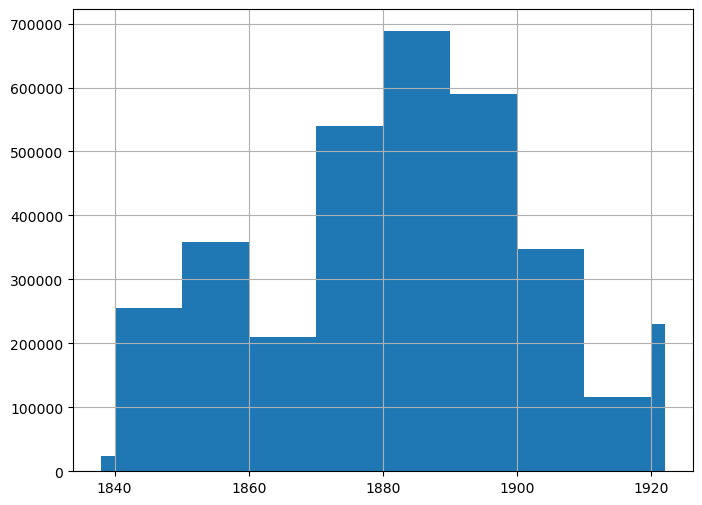

In [28]:
#binning data: e.g. 1860-1869 -> 1860 (1860s, but in order to keep it an integer, the "s" is ommitted)
rich_data["annee_bin"] = pd.cut(rich_data["annee"], right=False,
                bins=[1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930],
                labels=[1839, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920])
rich_data["annee_bin"].hist(bins=[1838, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1922])

In [29]:
# get only jobs with frequency in dataset higher than 50
freq_jobs = [metier for metier, count in Counter(rich_data["tags"]).items() if count>50]
print("number of frequent jobs:", len(freq_jobs))

# see how many rows include frequent jobs
print("all rows:", len(rich_data))
freq_job_data = rich_data[rich_data["tags"].isin(freq_jobs)]
print("only rows with frequent jobs:", len(freq_job_data))

number of frequent jobs: 3927
all rows: 3359249
only rows with frequent jobs: 2851788


<AxesSubplot:xlabel='annee'>

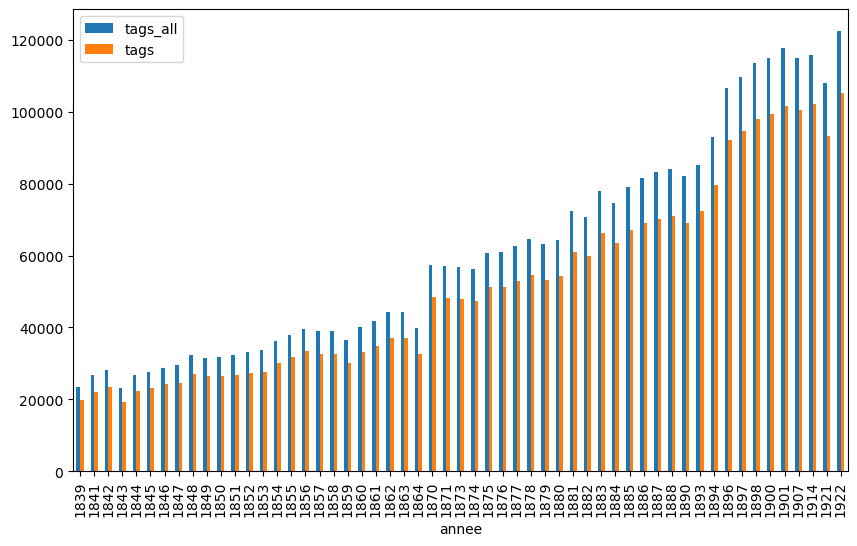

In [30]:
# check how the selection of frequent jobs puts bias in data

# create dataframe with absolute frequency of professions in rich_data and freq_job_data
count_year = rich_data.groupby(by="annee").count()[["tags"]]
count_year_freq = freq_job_data.groupby(by="annee").count()[["tags"]]
both_freq = count_year.join(count_year_freq, lsuffix="_all")

# this plot shows that the omitting of jobs with frequency <50 is affecting all years evenly
both_freq.plot.bar(y=["tags_all", "tags"], figsize=(10,6))

## First Analysis on Professions

In [31]:
# compare raw profession data and tags
print("Most frequent jobs in profession raw data:", Counter(rich_data["metier"]).most_common(10))
print("Most frequent jobs in tagged data:", Counter(rich_data["tags"]).most_common(10))

Most frequent jobs in profession raw data: [('vins', 219908), ('épicier', 90578), ('médecin', 53125), ('coiffeur', 48039), ('propriétaire', 46985), ('tailleur', 45777), ('boulanger', 43090), ('boucher', 42356), ('architecte', 34484), ('peintre-artiste', 27821)]
Most frequent jobs in tagged data: [('vins', 220869), ('épicier', 92042), ('propriétaire', 70277), ('médecin', 55488), ('coiffeur', 48624), ('tailleur', 47490), ('boulanger', 43935), ('boucher', 42757), ('architecte', 36165), ('artiste, peintre', 33380)]


[]

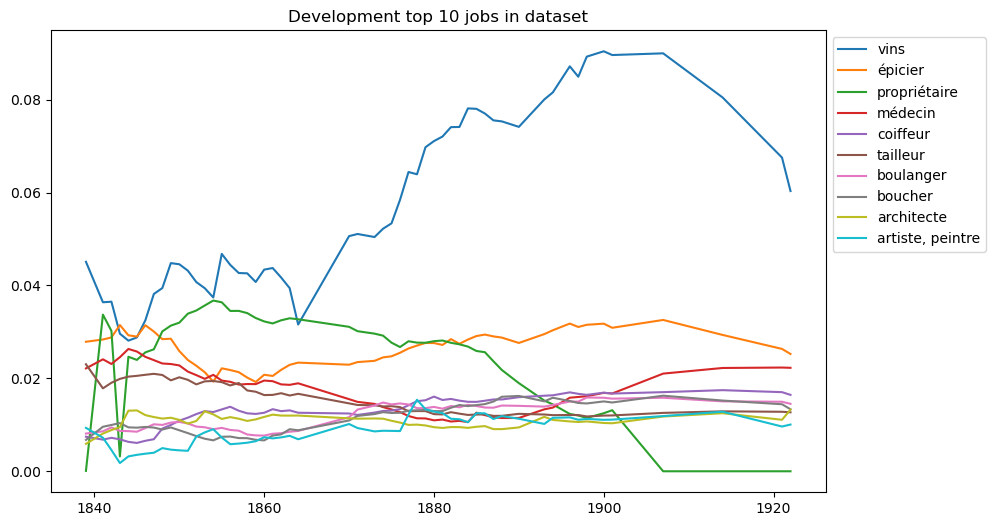

In [32]:
#get ratio of top 10 jobs in dataset
top_jobs10 = Counter(freq_job_data["tags"]).most_common(10)
top_jobnames10 = [name for name, count in top_jobs10]
plot_ratio_over_time(rich_data, top_jobnames10, title="Development top 10 jobs in dataset")

## Street statistics

[]

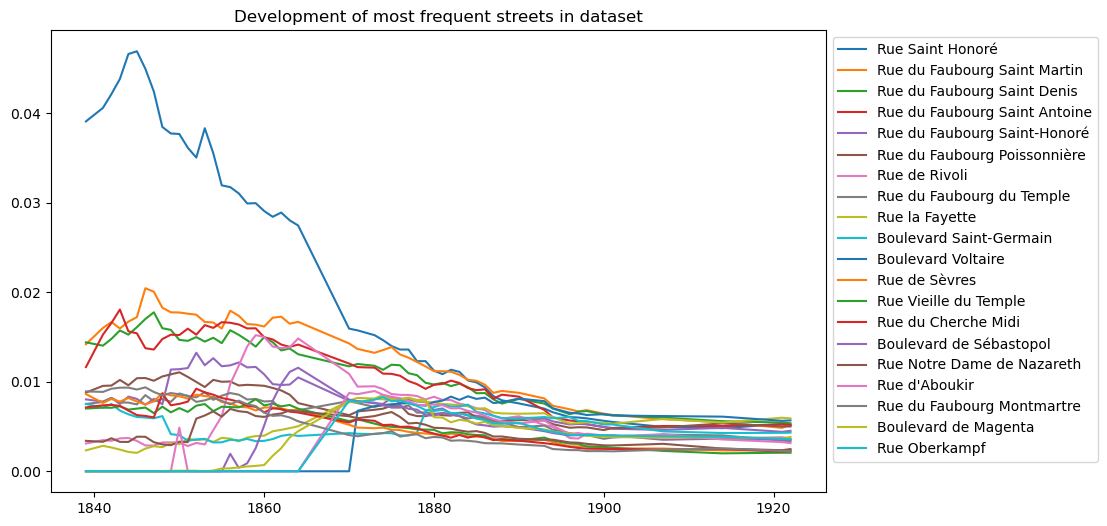

In [33]:
#look at most frequent streets
top_streets20 = Counter(rich_data["streetname"]).most_common(20)
top_streets20 = [name for name, count in top_streets20]

plot_ratio_over_time(rich_data, top_streets20, col_name="streetname",
        title="Development of most frequent streets in dataset")

### Looking at one street

[]

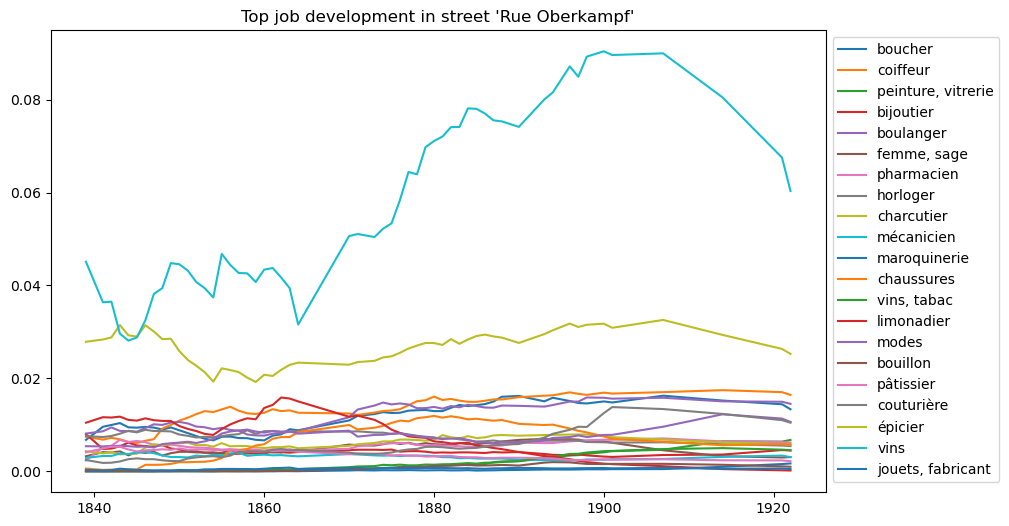

In [34]:
oberkampf_jobs = get_jobs_overtime(rich_data, "Rue Oberkampf")
plot_ratio_over_time(rich_data, oberkampf_jobs, title="Top job development in street 'Rue Oberkampf'")

[]

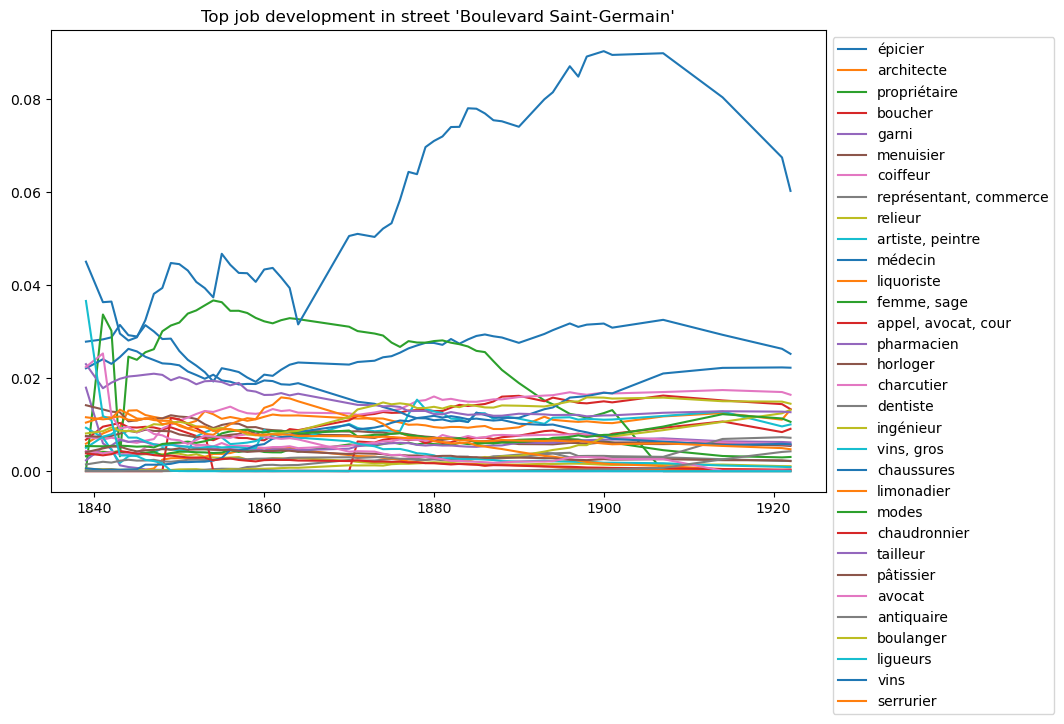

In [35]:
stgermain_jobs = get_jobs_overtime(rich_data, "Boulevard Saint-Germain")
plot_ratio_over_time(rich_data, stgermain_jobs, title="Top job development in street 'Boulevard Saint-Germain'")

### Most changing jobs

In [36]:
#safe number of bottin entries per year in a dict {year: #entries}
count_per_year = rich_data.groupby("annee").count()
count_per_year = dict(zip(count_per_year.index, count_per_year["row"]))
#count_per_year

In [37]:
df = rich_data.groupby(["tags", "annee"]).count()[["row"]]
df["job_ratio_by_year"] = df.apply(lambda x: x.row/count_per_year[x.name[1]], axis=1)
df


row  job_ratio_by_year
tags                         annee                        
                             1839    92           0.003910
                             1841    42           0.001572
                             1842    27           0.000958
                             1843    32           0.001384
                             1844    41           0.001527
...                                 ...                ...
îles, bois, tranchage        1922     2           0.000016
îles, noyer, bois, placage   1853     1           0.000030
óculenger                    1898     1           0.000009
ópicior                      1854     1           0.000028
örfáure, bijoutier, joailler 1879     1           0.000016

[589502 rows x 2 columns]

In [38]:
df_ratio = df[["job_ratio_by_year"]].groupby("tags").std().dropna().sort_values(by="job_ratio_by_year", ascending=False)
std_list = list(df_ratio.reset_index().head(20)["tags"])

[]

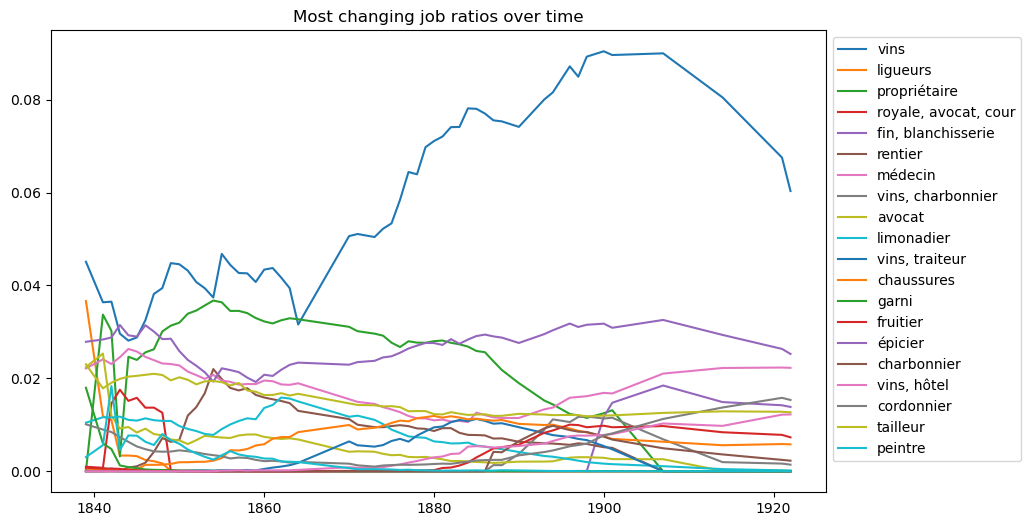

In [39]:
plot_ratio_over_time(rich_data, std_list, title="Most changing job ratios over time")

### Looking at certain jobs

<AxesSubplot:xlabel='annee'>

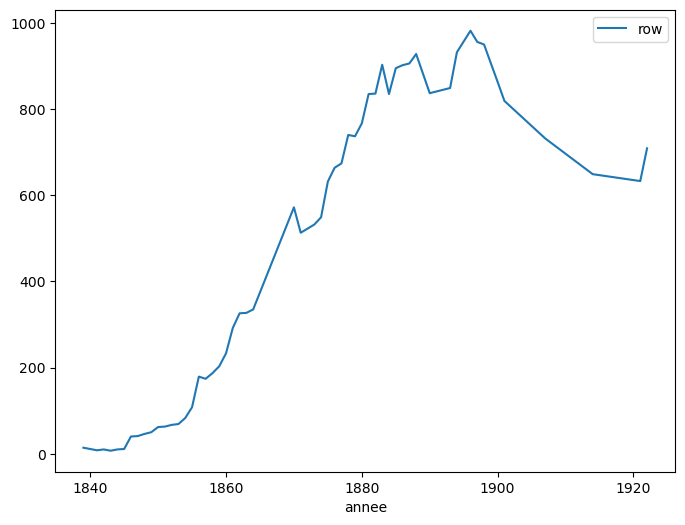

In [40]:
chaussures = rich_data[rich_data["tags"]=="chaussures"]
chaussures.groupby("annee").count()[["row"]].plot.line()

<AxesSubplot:xlabel='annee'>

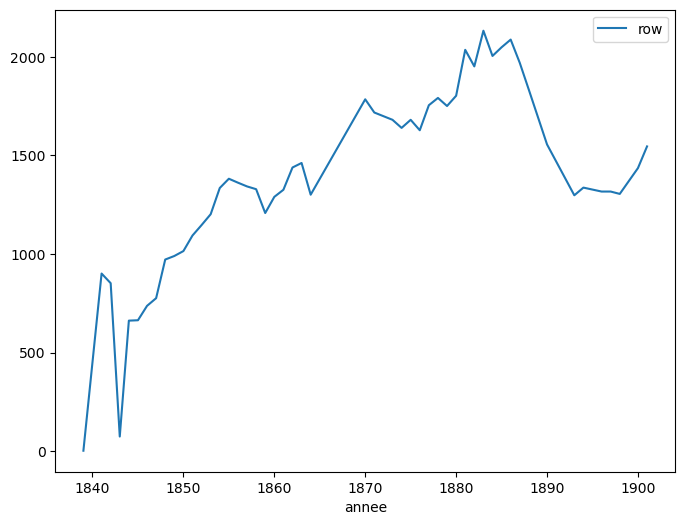

In [41]:
proprietaire = rich_data[rich_data["tags"]=="propriétaire"]
proprietaire.groupby("annee").count()[["row"]].plot.line()

# Professions which were born or died out

In [42]:
not_after1880, not_before1880 = jobs_not_before_after_specific_year(freq_job_data, 1880)

not_bef1880_one, _, _ = sort_by_number_of_words(not_before1880)
not_aft1880_one, _, _ = sort_by_number_of_words(not_after1880)
print("new profession entries - only after 1880 (one word entries):\n", not_bef1880_one, 
        "\n\nold profession entries - only before 1880 (one word entries):\n", not_aft1880_one)


new profession entries - only after 1880 (one word entries):
 ['triperie', 'massage', 'jerseys', 'garage', 'cycles', 'alimentation', 'brocanteuse', 'décolleteur', 'stoppeuse', 'ravalements', 'postiches', 'électriciens', 'importateurs', 'décolletage', 'pneumatiques', 'masseuse', 'masseur', 'charbonnière', 'phototypie', 'cannage', 'bicyclettes', 'poissonnerie', 'bar', 'reconnaissances', 'automobiles', 'outillage'] 

old profession entries - only before 1880 (one word entries):
 ['pair', 'grènetier', 'garni', 'bonnets', 'pension', 'mérinos', 'lettres', 'accordeur', 'prop', 'toiseur', 'huile']


[]

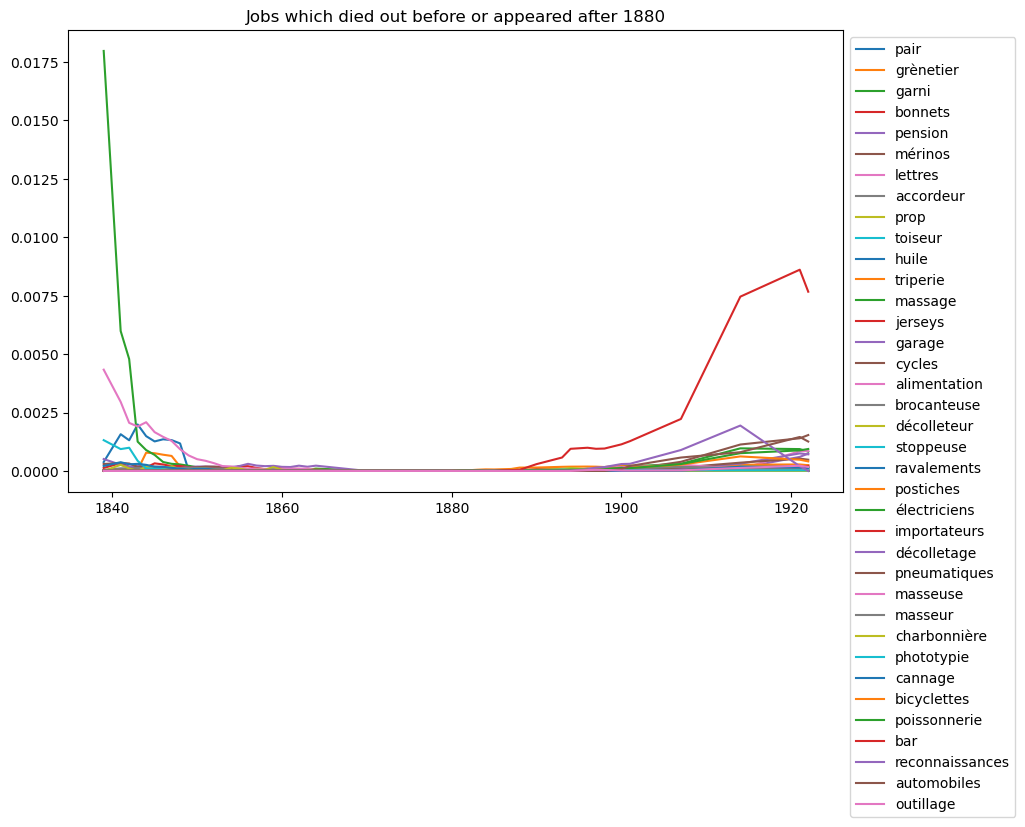

In [43]:
plot_ratio_over_time(rich_data, not_aft1880_one+not_bef1880_one, 
            title="Jobs which died out before or appeared after 1880")

### Working with geodata

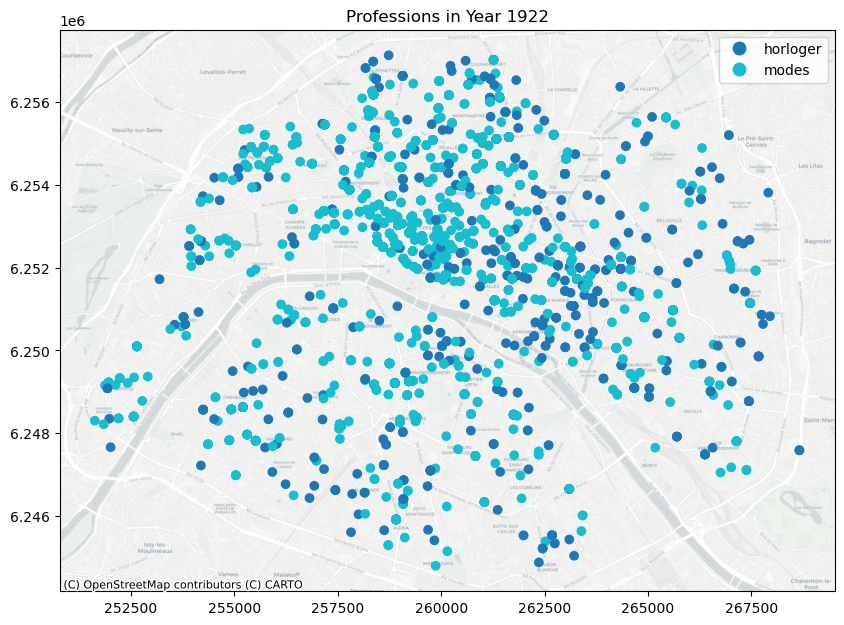

In [44]:
for year in [1922]:#sorted(rich_data["annee"].unique()):
    plot_profession_selection_on_map(rich_data, professions=["horloger", "modes"], year=year)

In [45]:
#make_gif(sorted(rich_data["annee"].unique()))

# Heatmaps
### with code from
https://nbviewer.org/gist/perrygeo/c426355e40037c452434

C:\Users\Ben\AppData\Local\Temp\ipykernel_17224\2758244975.py:24: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
C:\Users\Ben\AppData\Local\Temp\ipykernel_17224\2758244975.py:26: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')


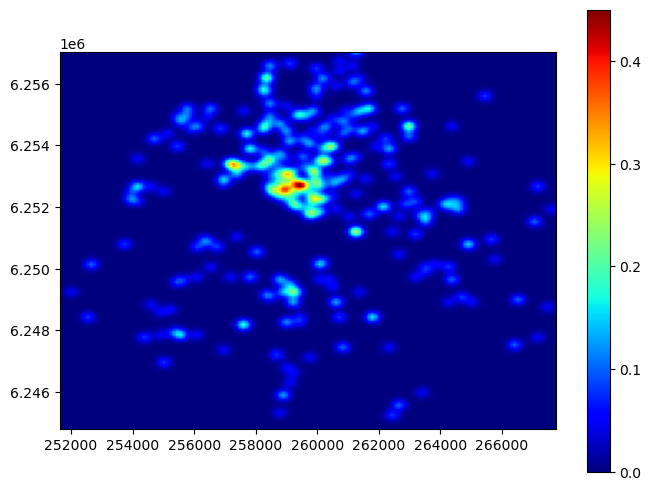

In [46]:
import geopandas as gpd
import numpy as np
from scipy import ndimage

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 8, 6

pts = rich_data[(rich_data["annee"]==1922) & (rich_data["metier"] == "modes")]
pts = pts.rename(columns={"geometry":"geo_col", "centroid":"geometry"})

def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

heatmap(pts, bins=150, smoothing=1.5)


# Gridwork

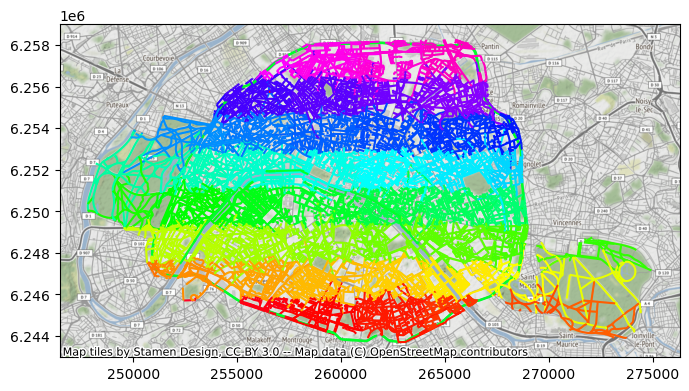

In [199]:
# Construct grid and assign gridnumbers
gridsize = 8
gridX, gridY = create_grid(gridsize, gridsize,rich_data)
assign_gridnumber(rich_data, gridX, gridY)

# Assign gridnumbers to streets too (makes dataViz quicker)
FinalUnique = pd.read_pickle("data/FinalUnique.pkl")
FinalUnique = gpd.GeoDataFrame(FinalUnique, geometry= "geometry")
FinalUnique = FinalUnique.drop(columns=["buffer", "filter"])
FinalUnique["centroid"] = FinalUnique.centroid
assign_gridnumber(FinalUnique, gridX, gridY)

# Show grid
matrix = FinalUnique.plot(column='grid',cmap='gist_rainbow')
cx.add_basemap(matrix, crs=FinalUnique.crs.to_string())


In [200]:
# function that creates dataframe with all jobs for a given bin and assigns jobs to that bin
def get_change_over_years(df, yearcolumn="annee_bin"):
    pivot = pd.pivot_table(df, values= "rue", index= "tags", columns = yearcolumn, aggfunc="count")
    pivot = pivot.fillna(0)
    pivot = pivot.iloc[1:,1:]
    pivot_rel = pivot.apply(lambda col: col/sum(col))
    change_year = []
    for year in range(1, len(pivot_rel.columns)):
        dif = sum(abs(pivot_rel.iloc[:,year] - pivot_rel.iloc[:,year-1]))/2
        change_year.append(dif)
    return(change_year, pivot.columns[1:])

In [201]:
groupby = "annee"
profession_change_regions = []
profession_change_years = []
# change in all of paris
change_all, years = get_change_over_years(rich_data, yearcolumn= groupby)
profession_change_regions.append(change_all)
profession_change_years.append(years)

for i in range(1,gridsize**2+1):
    # change in all other subgrids
    subset = rich_data.loc[rich_data.grid == i]
    change_in_grid, years = get_change_over_years(subset, yearcolumn= groupby)
    profession_change_regions.append(change_in_grid)
    profession_change_years.append(years)



In [202]:
groupby = "annee_bin"
profession_change_regions_bin = []
profession_change_years_bin = []

# change in all of paris
change_all, years = get_change_over_years(rich_data, yearcolumn= groupby)
profession_change_regions_bin.append(change_all)
profession_change_years_bin.append(years)

for i in range(1,gridsize**2+1):
    # change in all other subgrids
    subset = rich_data.loc[rich_data.grid == i]
    change_in_grid, years = get_change_over_years(subset, yearcolumn = groupby)
    profession_change_regions_bin.append(change_in_grid)
    profession_change_years_bin.append(years)



In [203]:
profession_change_regions_bin

[[0.2845614902829878,
  0.2142461761781325,
  0.3179570145527296,
  0.2215532993027335,
  0.24129298046033681,
  0.18461054100544683,
  0.2606349380584219,
  0.16467209007943995],
 [],
 [],
 [nan,
  1.0000000000000002,
  1.0000000000000002,
  0.7888888888888889,
  0.9000000000000001,
  0.7749999999999999,
  0.7083333333333334,
  0.6111111111111112],
 [nan,
  1.0000000000000004,
  0.6714318337519971,
  0.45138433634893643,
  0.48157092654342865,
  0.3640054662638493,
  0.4198804066258591,
  0.25368189906485433],
 [0.5560534822215691,
  0.7065659086048337,
  0.581164515919186,
  0.3535652480996955,
  0.28049665887754566,
  0.2508551854825848,
  0.3140736126793113,
  0.19203580813778506],
 [1.0,
  nan,
  nan,
  0.4422121212121216,
  0.4187780466898605,
  0.2846421766830756,
  0.4396630146738922,
  0.3114618177659608],
 [0.6685714285714287, 0.875, nan, nan, nan, nan, nan, nan],
 [nan,
  nan,
  nan,
  nan,
  0.7199546485260768,
  0.6115646258503401,
  0.6238095238095238,
  0.643772893772893

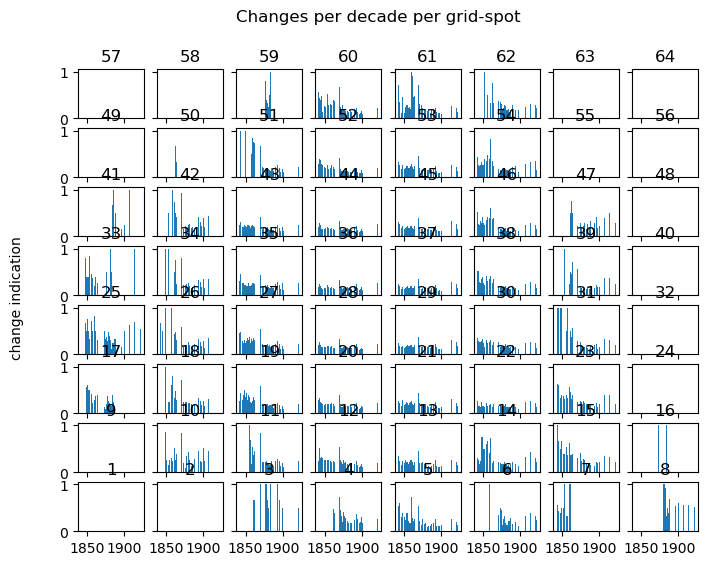

In [229]:
fig, axs = plt.subplots(gridsize,gridsize, sharex=True, sharey=True)
for i in range(1,gridsize**2+1):
    x = gridsize - floor((i-1)/gridsize)-1
    y = (i-1)%gridsize
    axs[x][y].bar(profession_change_years[i],profession_change_regions[i])
    axs[x][y].set_title(f"{i}")    
fig.text(0.04, 0.5, 'change indication', va='center', rotation='vertical')
plt.suptitle("Changes per decade per grid-spot")
plt.show()


In [214]:
hm = np.zeros((gridsize, gridsize))   
for i in range(1,gridsize**2+1):
    x = gridsize - floor((i-1)/gridsize)-1
    y = (i-1)%gridsize
    hm[x,y] = profession_change_regions[i][0]


7 0


IndexError: list index out of range

In [224]:
profession_change_regions[4]

[nan,
 nan,
 nan,
 1.0,
 1.0,
 nan,
 nan,
 nan,
 0.42236024844720477,
 0.47714604236343355,
 0.38394062078272606,
 0.3929824561403509,
 0.7313725490196077,
 0.45903361344537774,
 0.3285891089108914,
 0.2043204320432044,
 0.40650199473728843,
 0.24194957983193302,
 0.31948387096774195,
 0.27625296154547135,
 0.2626665458170941,
 0.2352092352092355,
 0.2109757598129693,
 0.18340380549682897,
 0.24545454545454498,
 0.21107350096711774,
 0.18689687245669087,
 0.18066851181605242,
 0.23951048951048962,
 0.19390341202421707,
 0.24698425231390086,
 0.36476190476190445,
 0.2538575119970474,
 0.33550787931724846,
 0.16874192011975198,
 0.20249137711369153,
 0.29620882733703296,
 0.17649497299956393,
 0.373039559447897,
 0.3666685674640515,
 0.26190868428659797,
 0.168840374934741]

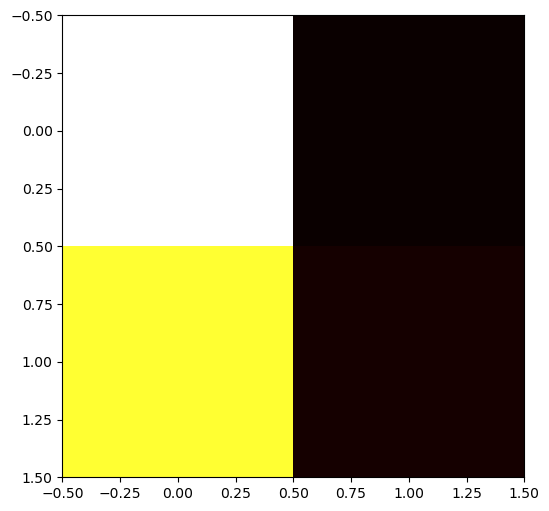

In [ ]:
plt.imshow(hm, cmap='hot', interpolation='nearest')